- 잠재공간을 이용하는 두가지  생성 모델
  - 변이형 오토인코더(VAE)
  - 생성적 적대 신경망(GAN)

- 자기회귀모델(autoregressive model)
  - 잠재 확률변수가 아니라 시퀀스에 있는 이전값을 바탕으로 예측을 만듦
  

In [ ]:
# 자기회귀모델 LSTM(텍스트 데이터),  PixelCNN(이미지 데이터)

In [ ]:
# https://drive.google.com/file/d/1CPCu895GkGPrvChspl7iPBkoqpBzKCOO/view?usp=sharing

In [ ]:
!unzip '/content/drive/MyDrive/레시피데이터셋/Epicurious - Recipes with Rating and Nutrition.zip'

Archive:  /content/drive/MyDrive/레시피데이터셋/Epicurious - Recipes with Rating and Nutrition.zip
  inflating: epi_r.csv               
  inflating: full_format_recipes.json  
  inflating: recipe.py               
  inflating: utils.py                


In [ ]:
import pandas as pd
import numpy as np
import json

In [ ]:
with open('/content/full_format_recipes.json')as json_data:
  recipe_data =  json.load(json_data)
recipe_data[0].keys()


dict_keys(['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium'])

In [ ]:
recipe_data[0]['title'],recipe_data[0]['directions']

('Lentil, Apple, and Turkey Wrap ',
 ['1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.',
  '2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper.',
  '3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.'])

In [ ]:
temp = recipe_data[0]
temp['title']+" : " + ' '.join(temp['directions'])

'Lentil, Apple, and Turkey Wrap  : 1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool. 2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper. 3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.'

In [ ]:
filtered_data = []
for rd in recipe_data:
  if ('title' in rd) and (rd['title'] is not None) and (rd['directions'] is not None):
    filtered_data.append( rd['title']+" : " + ' '.join(rd['directions']) )

In [ ]:
filtered_data[:3]

['Lentil, Apple, and Turkey Wrap  : 1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool. 2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper. 3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.',
 'Boudin Blanc Terrine with Red Onion Confit  : Combine first 9 ingredients in heavy medium saucepan. Add 3 shallo

- 텍스트를 토큰화
  - 단어나 문자로 나누는 작업
- 단어 토큰
  - 모든 텍스트를 소문자로 변환
  - 어휘사전(vocabulary)이 매우 클 수도 있음
  - 어간(stem) : 현재 과거, 진행
  - 마침표와 쉼표를 제거
  - 훈련어휘에 없는 단어는 예측 불가
- 문자 토큰
  - 시퀀스를 생성해서 훈련 어휘에 없는 새로운 단어를 생성가능
  - 어휘사전이 매우 작아진다 그래서 마지막 출력층에 학습할 가중치가 적기때문에 훈련속도에 유리

In [ ]:
# 텍스트 전처리
import string
import re
def pad_punctuation(s):
  s = re.sub(f"([{string.punctuation}])", r' \1', s)
  s = re.sub(' +',' ',s)
  return s
pad_punctuation("!!!abc#$")

' ! ! !abc # $'

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
text_data = [pad_punctuation(x) for x in filtered_data]
text_data[:5]

['Lentil , Apple , and Turkey Wrap : 1 . Place the stock , lentils , celery , carrot , thyme , and salt in a medium saucepan and bring to a boil . Reduce heat to low and simmer until the lentils are tender , about 30 minutes , depending on the lentils . (If they begin to dry out , add water as needed . ) Remove and discard the thyme . Drain and transfer the mixture to a bowl ; let cool . 2 . Fold in the tomato , apple , lemon juice , and olive oil . Season with the pepper . 3 . To assemble a wrap , place 1 lavash sheet on a clean work surface . Spread some of the lentil mixture on the end nearest you , leaving a 1 -inch border . Top with several slices of turkey , then some of the lettuce . Roll up the lavash , slice crosswise , and serve . If using tortillas , spread the lentils in the center , top with the turkey and lettuce , and fold up the bottom , left side , and right side before rolling away from you .',
 'Boudin Blanc Terrine with Red Onion Confit : Combine first 9 ingredients

In [ ]:
# 텐서플로의 데이터셋으로 변환
import tensorflow as  tf

In [ ]:
text_ds = tf.data.Dataset.from_tensor_slices(text_data).batch(32).shuffle(1000)

In [ ]:
import tensorflow.keras.layers as layers

In [ ]:
vectorize_layer =  layers.TextVectorization(
    standardize= 'lower',  # 소문자로 변경
    max_tokens = 10000, # 자주 등장하는 1000개의 단어에 정수를 부여
    output_mode = 'int',
    output_sequence_length = 200+1  # 시퀀스의 길이가 201개의 토큰으로 자르거나 패팅
)

In [ ]:
#벡터화를 한 층
vectorize_layer.adapt(text_ds)  # TextVectorization층을 훈련데이터에 적용
vocab =  vectorize_layer.get_vocabulary() # vocab변수에 단어리스트를 저장
vocab

['',
 '[UNK]',
 '.',
 ',',
 'and',
 'to',
 'in',
 'the',
 'with',
 'a',
 'until',
 '1',
 'minutes',
 'of',
 'heat',
 'add',
 'about',
 'over',
 'bowl',
 ';',
 ':',
 '2',
 'salt',
 'into',
 'on',
 'large',
 'medium',
 'mixture',
 ')',
 'pepper',
 'oil',
 'is',
 'water',
 'transfer',
 '3',
 'stir',
 'or',
 'cook',
 'pan',
 'remaining',
 'then',
 'oven',
 'for',
 'stirring',
 'cover',
 'from',
 'butter',
 'skillet',
 'sugar',
 'at',
 'sauce',
 'cup',
 '/2',
 'baking',
 '5',
 'cool',
 '-inch',
 'season',
 'be',
 'place',
 'it',
 'small',
 '4',
 'each',
 'let',
 'serve',
 'boil',
 'simmer',
 'remove',
 'top',
 'whisk',
 '/4',
 'cut',
 'heavy',
 'ahead',
 'are',
 'saucepan',
 'cream',
 'garlic',
 'bring',
 'chicken',
 '10',
 'preheat',
 'using',
 'sprinkle',
 'tablespoons',
 'occasionally',
 'just',
 'brown',
 'tender',
 'dough',
 'bake',
 'side',
 'spoon',
 'golden',
 'up',
 'pot',
 'through',
 'combine',
 'juice',
 'sheet',
 'if',
 'hours',
 'pour',
 'chill',
 'lemon',
 'together',
 'flour

In [ ]:
import numpy as np
import json
import re
import string
import tensorflow as tf
from tensorflow.keras import layers,models,callbacks,losses

In [ ]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
BATCH_SIZE = 32
EPOCHS = 25

In [ ]:
# 토큰,단어 매핑
for i, word in enumerate( vocab[:10]):
  print(f"{i}:{word}")

0:
1:[UNK]
2:.
3:,
4:and
5:to
6:in
7:the
8:with
9:a


In [ ]:
example_data = text_data[0]
print(example_data)
example_tokenised =  vectorize_layer(example_data)
print(example_tokenised.numpy())

Lentil , Apple , and Turkey Wrap : 1 . Place the stock , lentils , celery , carrot , thyme , and salt in a medium saucepan and bring to a boil . Reduce heat to low and simmer until the lentils are tender , about 30 minutes , depending on the lentils . (If they begin to dry out , add water as needed . ) Remove and discard the thyme . Drain and transfer the mixture to a bowl ; let cool . 2 . Fold in the tomato , apple , lemon juice , and olive oil . Season with the pepper . 3 . To assemble a wrap , place 1 lavash sheet on a clean work surface . Spread some of the lentil mixture on the end nearest you , leaving a 1 -inch border . Top with several slices of turkey , then some of the lettuce . Roll up the lavash , slice crosswise , and serve . If using tortillas , spread the lentils in the center , top with the turkey and lettuce , and fold up the bottom , left side , and right side before rolling away from you .
[1841    3  431    3    4  218  206   20   11    2   59    7  298    3
  924  

In [ ]:
# 훈련세트 만들기
# LSTM은 단어시퀀스가 주어지면 이 시퀀스의 다음 단어를 예측하도록 훈련
# 전체시퀀스를 한 토큰 이동시켜서 타깃 변수를 만듦
def prepare_inputs(text):
  text =  tf.expand_dims(text,-1)
  tokenized_sentences =  vectorize_layer(text)
  x = tokenized_sentences[:, :-1]
  y =  tokenized_sentences[:, 1:]
  return x,y
train_ds = text_ds.map(prepare_inputs)

In [ ]:
# LSTM : inputlayer - embedding - lstm - dense

In [ ]:
inputs = layers.Input(shape=(None,),dtype = 'int32') # 시퀀스의 길이는 가변적
x = layers.Embedding(VOCAB_SIZE,EMBEDDING_DIM)(inputs)  # 어휘사전의크기, 임베딩 벡터의 차원
x = layers.LSTM(N_UNITS,return_sequences=True)(x) # 은닉벡터의 차원을 지정, 전체 타임스템프의 은닉상태 반환
outputs = layers.Dense(VOCAB_SIZE,activation = 'softmax')(x) # 확률 벡터로 변환
lstm = models.Model(inputs,outputs)
lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 dense (Dense)               (None, None, 10000)       1290000   
                                                                 
Total params: 2407248 (9.18 MB)
Trainable params: 2407248 (9.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 콜벡함수
model_checkpoint_callback = callbacks.ModelCheckpoint(
    'checkpoint.ckpt',
    save_weights_only = True,
    save_freq = 'epoch',
    verbose = 0
)
tensorboard_callback = callbacks.TensorBoard(log_dir = './logs')

In [ ]:
# TextGenerator 체크포인트 만들기
class TextGenerator(callbacks.Callback):
  # 어휘사전(단어에서 토큰)
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature): # temperature 사용해서 확률을 업데이트
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
      # 생성과정을 시작하기 위해서 모델에 제공하는 단어의 문자열
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0: # 조건에 부합될때까지 시퀀스를 생성
            x = np.array([start_tokens])
            y = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature) # temperature기반으로 다음단어 예측
            info.append({"prompt": start_prompt, "word_probs": probs})
            start_tokens.append(sample_token)  # 다음반복을 위해서 새로운 단어를 추가
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\n생성된 텍스트:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("recipe for", max_tokens=100, temperature=1.0)

text_generator = TextGenerator(vocab)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
lstm.compile('adam',loss_fn)
lstm.fit(train_ds,epochs=25,
         callbacks=[model_checkpoint_callback,tensorboard_callback,text_generator])

Epoch 1/25
629/629 [==============================] - ETA: 0s - loss: 2.1201
생성된 텍스트:
recipe for 450°f primavera : add fresh herbs , mozzarella , quartered , curry , onion , rice , and salt ; stir to paste . whisk until yolks are smooth and smooth . using tongs , transfer to a buttered /2 cup of rice , reserving 1 sides and roast until flavors to prevent cabbage forms . 

629/629 [==============================] - 51s 77ms/step - loss: 2.1201
Epoch 2/25
628/629 [============================>.] - ETA: 0s - loss: 2.0071
생성된 텍스트:
recipe for already salmon . *available at charcoal thermometer consistency of curd registers eastern is burn ; plunging mussels and bake for 40 hen with turning occasionally . transfer tomatoes to puddings and cut tomatoes : place garlic free of shrimp strips in burner . pour into large saucepan with ice water . drain . meanwhile , add lentils , and sugar in a large bowl and boil until mixture is just thermometer registers dente . using oiled wet back of a large 

PixelCNN
  - 마스크드 합성곱 층
    - 이미지의 각 픽셀을 생성할때 이전 픽셀들만 보고 생성하도록 설계
    - 이전 픽셀위치에 따라서 가리는마스크를 사용해서 필터 연산
  - 잔차 블럭
    - 심층신경망 기울기 소실문제를 해결하는데 사용
    - 입력과 출력을 더함,

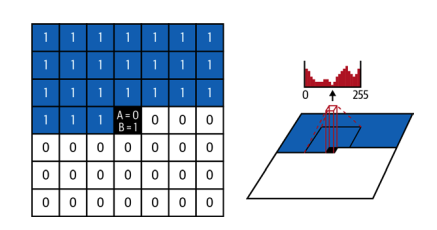

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

In [ ]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

In [ ]:
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [ ]:
# 데이터 전처리
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

In [ ]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs) # Conv2D를 기반으로 함

    def build(self, input_shape):
        # conv2d 층을 만들고 커널 변수를 초기화합니다.
        self.conv.build(input_shape)
        # 초기화된 커널을 사용해 마스크를 만듭니다.
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0 # 이전행의 픽셀은 마스킹을 해제하기 위해 1로 지정
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0  # 동일행에 있는 이전열의 픽셀은 마스킹을 해제하기위해서 1로 지정
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0  # 마스크유형이 B이면 중앙 픽셀은 마스킹을 해제하기위해 1로 지정

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)  # 마스크와 필터 가중치를 곱함
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg
# 여기서 사용하는 이미지는 채널이 하나인 흑백

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        ) # Conv2 층은 채널수를 절반으로 줄인다

        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        ) # 커널크기가 3인 B유형의 MaskedConv2D은 5개의 픽셀정보만 사용

        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        ) # 마지막 층은 입력크기에 맞춰서 다시 채널수를 두배로 늘린다

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])  # 합성곱층의 출력을 입력층에 더한다... 스킵커넥션(잔차 블럭)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [ ]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))  # 흑백 16 16 1 입력값의 범위는 0 ~ 1
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)  # kernel_size=7 A형 MaskedConv2D 24개의 픽셀정보를 사용


for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)  # 5개의 잔차블럭을 순서대로 쌓는다

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d_16 (MaskedCo  (None, 16, 16, 128)       6400      
 nv2D)                                                           
                                                                 
 residual_block_10 (Residua  (None, 16, 16, 128)       53504     
 lBlock)                                                         
                                                                 
 residual_block_11 (Residua  (None, 16, 16, 128)       53504     
 lBlock)                                                         
                                                                 
 residual_block_12 (Residua  (None, 16, 16, 128)       53504     
 lBlock)                                                   

In [ ]:
# 이미지 제너레이터
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해
            generated_images = self.generate(temperature=1.0)
            display(
                generated_images,
                # save_to=".generated_img_%03d.png" % (epoch),
            )

In [ ]:
adam = optimizers.Adam(learning_rate = 0.0005)
pixel_cnn.compile(optimizer=adam, loss = tf.keras.losses.sparse_categorical_crossentropy)

Epoch 1/150
  5/469 [..............................] - ETA: 17s - loss: 0.8517

469/469 [==============================] - ETA: 0s - loss: 0.4149

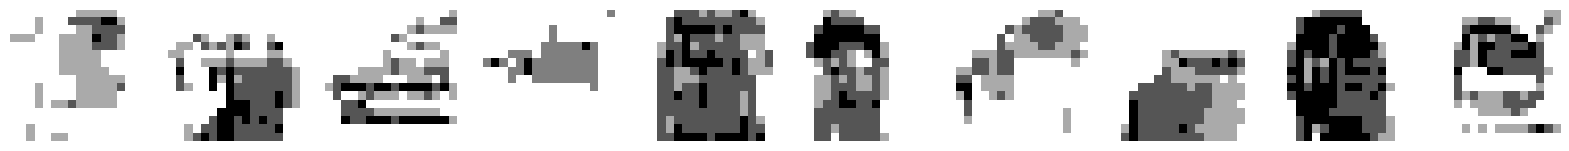

469/469 [==============================] - 34s 60ms/step - loss: 0.4149
Epoch 2/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3896
Epoch 3/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3823
Epoch 4/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3778
Epoch 5/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3732
Epoch 6/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3706
Epoch 7/150
469/469 [==============================] - 14s 29ms/step - loss: 0.3680
Epoch 8/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3656
Epoch 9/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3634
Epoch 10/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3615
Epoch 11/150
469/469 [==============================] - ETA: 0s - loss: 0.3597

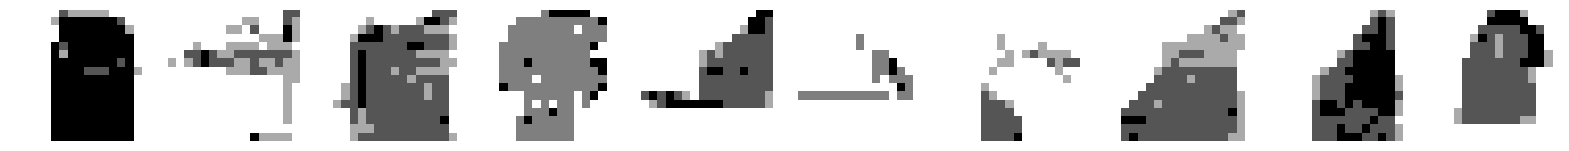

469/469 [==============================] - 28s 59ms/step - loss: 0.3597
Epoch 12/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3577
Epoch 13/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3562
Epoch 14/150
469/469 [==============================] - 13s 29ms/step - loss: 0.3548
Epoch 15/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3535
Epoch 16/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3524
Epoch 17/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3511
Epoch 18/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3506
Epoch 19/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3492
Epoch 20/150
469/469 [==============================] - 13s 28ms/step - loss: 0.3485
Epoch 21/150
469/469 [==============================] - ETA: 0s - loss: 0.3480

KeyboardInterrupt: ignored

In [ ]:
img_generator_callback = ImageGenerator(num_img = 10)
tensorboard_callback = callbacks.TensorBoard(log_dir = "./logs")
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)